<a href="https://colab.research.google.com/github/shahchayan9/Dimensionality-Reduction/blob/main/RandomizedPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Randomized PCA

Randomized PCA (Principal Component Analysis) is an efficient algorithm for computing an approximate low-rank decomposition of large datasets, particularly useful when the dataset has high dimensions or when the exact computation of PCA is computationally expensive.

#### How it Works:
1. **Random Projection:**  
   - Projects the data matrix \( X \) (of size \( n \times d \)) onto a lower-dimensional subspace using a random matrix.  
   - This reduces the number of dimensions while retaining most of the original data's variance.

2. **Low-rank Approximation:**  
   - An SVD (Singular Value Decomposition) is performed on the reduced matrix to compute the principal components.

3. **Dimensionality Reduction:**  
   - The approximate principal components are reconstructed, reducing computational complexity.

#### Advantages:
- **Speed:** Faster than traditional PCA for high-dimensional datasets.
- **Scalability:** Suitable for large datasets.
- **Memory Efficiency:** Avoids storing large intermediate matrices.

#### Use Cases:
- Large-scale machine learning problems.
- Real-time dimensionality reduction.
- Visualization of high-dimensional data.

#### Limitations:
- **Approximation Accuracy:** Results are approximate and depend on hyperparameters.
- **Randomness Dependency:** Different runs may yield slightly different results due to stochasticity.


In [ ]:
# prompt: pull dataset from https://www.kaggle.com/datasets/phylake1337/fire-dataset/data

import os
from google.colab import files

# Install the Kaggle API client.
!pip install kaggle

# Upload your Kaggle API key file.
files.upload()

# Make sure the Kaggle API key is in the correct location.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset.  Replace with the actual dataset name and path.
!kaggle datasets download -d phylake1337/fire-dataset

# Unzip the dataset.
!unzip fire-dataset.zip

In [ ]:
!pip install keras

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob


from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import  to_categorical



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
base_folder = '.'
data_folder = 'fire_dataset'
train_data_folder = 'fire_dataset/fire_images'
test_date_folder  = 'fire_dataset/non_fire_images'

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [ ]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []

    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 230.94it/s]


In [ ]:
#show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


In [ ]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(999, 3)

,file,id,label
0,fire_images/fire.237.png,0,fire_images
1,fire_images/fire.599.png,0,fire_images
2,fire_images/fire.645.png,0,fire_images
3,fire_images/fire.167.png,0,fire_images
4,fire_images/fire.429.png,0,fire_images


In [ ]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

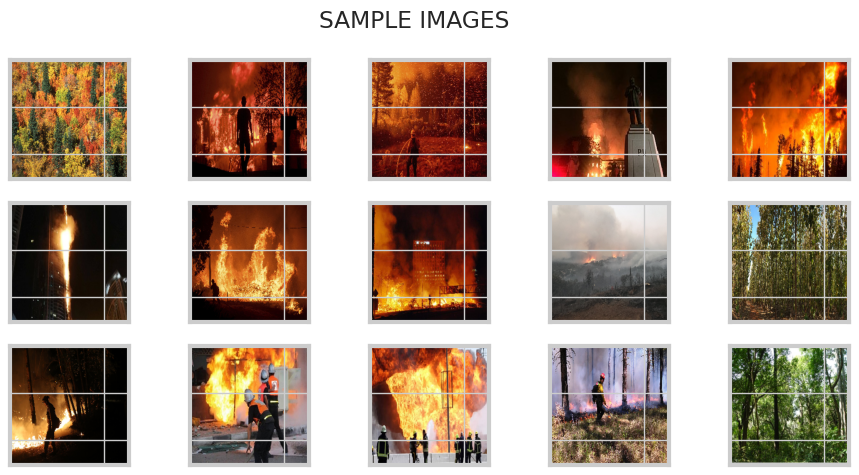

In [ ]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

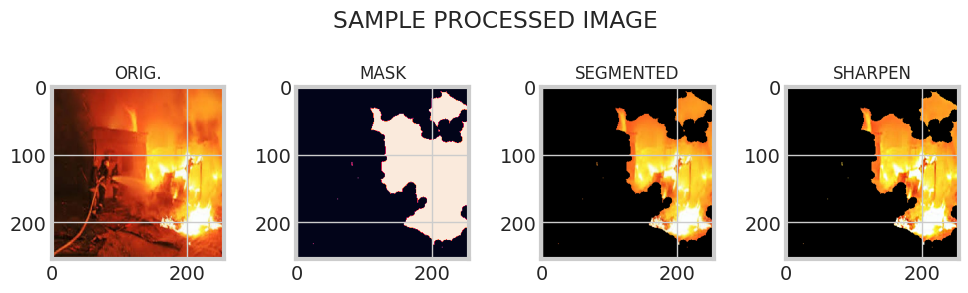

In [ ]:
img = read_img(df['file'][102],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);

In [ ]:
# from tensorflow import keras
# def load_images(data_folder, categories):
#     data = []
#     labels = []
#     for label, category in enumerate(categories):
#         category_path = os.path.join(data_folder, category)
#         for file_name in os.listdir(category_path):
#             file_path = os.path.join(category_path, file_name)
#             # image = read_img(, (255,255))
#             image1 = keras.preprocessing.image.load_img(file_path, target_size=(255, 255),color_mode='rgb')
#             image1 = keras.preprocessing.image.img_to_array(image1)
#             if image1 is not None:
#               original_image = image1.copy()
#               image1 = segment_image(original_image) # Use original image for segmentation
#               image1 = create_mask_for_plant(image1)
#               image1 = sharpen_image(image1)
#               image1 = cv2.resize(image1, (64, 64))
#               data.append(image1.flatten())
#               labels.append(label)
#     return np.array(data), np.array(labels)

# categories = ['fire_images', 'non_fire_images']
# data_folder = 'fire_dataset'
# X, y = load_images(data_folder, categories)

import numpy as np
import pandas as pd
import os
import cv2
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_images(data_folder, categories):
    data = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(data_folder, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                image = cv2.resize(image, (64, 64))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                data.append(image.flatten())
                labels.append(label)
    return np.array(data), np.array(labels)

categories = ['fire_images', 'non_fire_images']
data_folder = 'fire_dataset'
X, y = load_and_preprocess_images(data_folder, categories)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
n_components = 50  # Number of principal components to keep
pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

classifier = LogisticRegression(random_state=42, max_iter=1000)
classifier.fit(X_train_pca, y_train)

y_pred = classifier.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

LogisticRegression(max_iter=1000, random_state=42)

Accuracy: 74.50%


<Figure size 800x600 with 0 Axes>

<Axes: ylabel='count'>

Text(0.5, 1.0, 'Distribution of Fire and Non-Fire Images')

Text(0.5, 0, 'Class (0: Fire, 1: Non-Fire)')

Text(0, 0.5, 'Count')

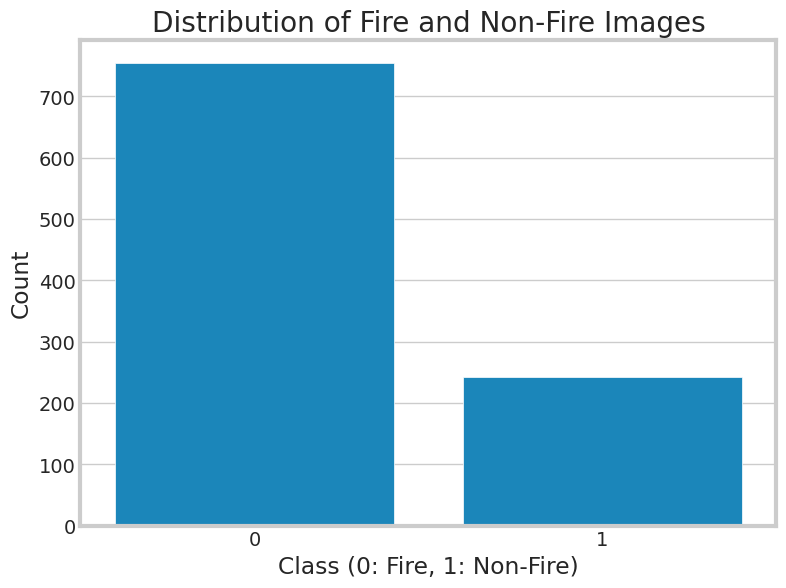

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribution of Fire and Non-Fire Images')
plt.xlabel('Class (0: Fire, 1: Non-Fire)')
plt.ylabel('Count')
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Number of Components')

Text(0, 0.5, 'Cumulative Explained Variance')

Text(0.5, 1.0, 'Explained Variance Ratio by PCA Components')

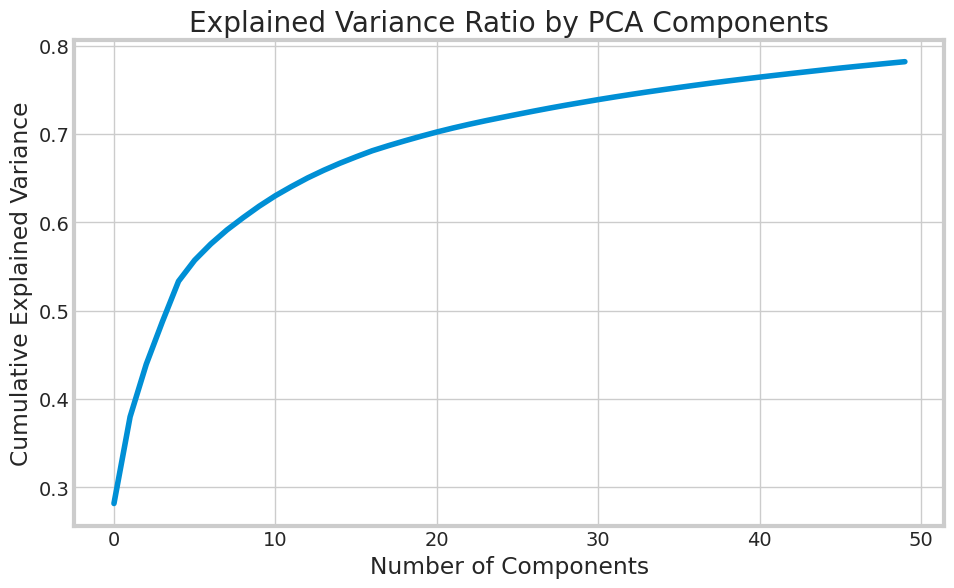

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio by PCA Components')
plt.grid(True)
plt.show()

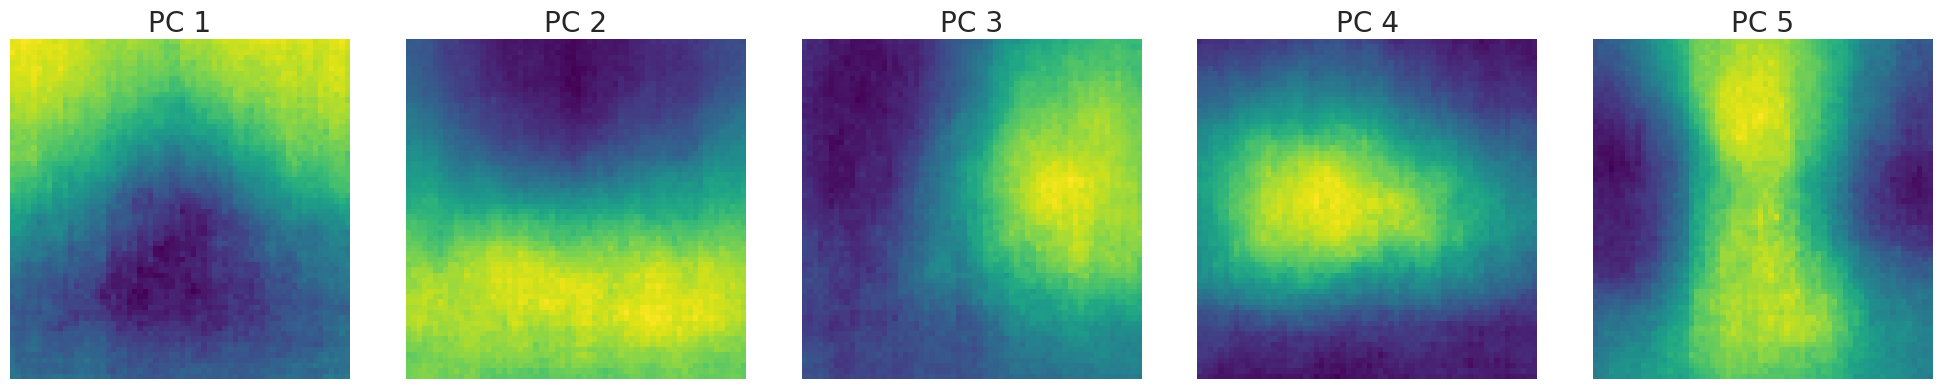

In [ ]:
def plot_pca_components(pca, n_components=5):
    fig, axes = plt.subplots(1, n_components, figsize=(20, 4))
    for i, ax in enumerate(axes.flat):
        pc = pca.components_[i].reshape(64, 64)
        ax.imshow(pc, cmap='viridis')
        ax.set_title(f'PC {i+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_pca_components(pca)

LogisticRegression(max_iter=1000, random_state=42)

Accuracy: 74.50%


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 12.583333333333302, 'Predicted')

Text(34.58333333333333, 0.5, 'Actual')

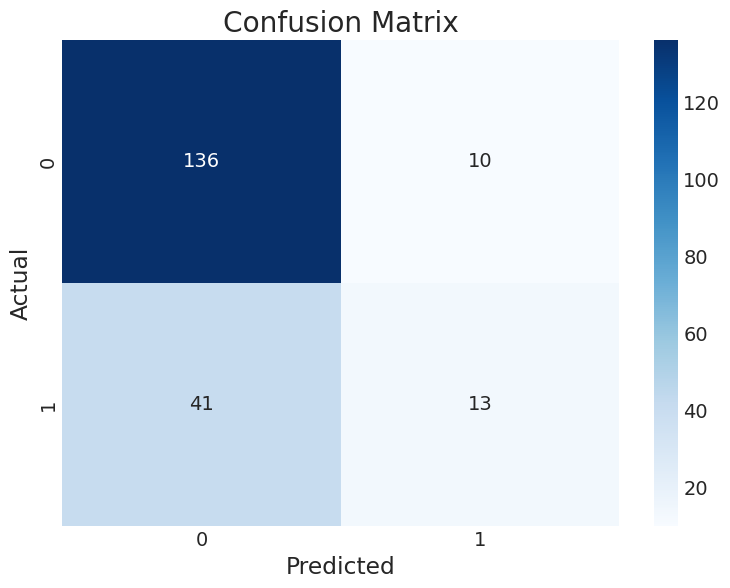

In [ ]:
classifier = LogisticRegression(random_state=42, max_iter=1000)
classifier.fit(X_train_pca, y_train)

y_pred = classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()